# <center> Линейная алгебра в контексте линейных методов. Практика.

## <center> Прогнозирование выработки газа на скважинах.

## Постановка задачи

У Василия, основателя компании «Газ-Таз-Ваз-Нефть», дела идут в гору: у него уже функционирует 200 скважин для добычи газа. В этом году он открывает 30 новых скважин. Однако в целях оптимизации расходов и повышения дохода Василию необходимо оценить, сколько денег будет приносить ему каждая из скважин, а также понять, какие факторы (параметры скважин) потенциально сильнее всего повлияют на объём добычи газа. Для этого Василий решил нанять вас как специалиста в области Data Science.

Василий представляет вам набор данных о добыче газа на своих скважинах. Файл с данными вы можете скачать на платформе.

**Признаки в данных:**

* Well — идентификатор скважины;
* Por — пористость скважины (%);
* Perm — проницаемость скважины;
* AI — акустический импеданс ($кг/м^2 * 10^6$);
* Brittle — коэффициент хрупкости скважины (%);
* TOC — общий органический углерод (%);
* VR — коэффициент отражения витринита (%);
* Prod — добыча газа в сутки (млн. кубических футов).

**Ваша задача** — построить регрессионную модель, которая прогнозирует выработку газа на скважине (целевой признак — Prod) на основе остальных характеристик скважины, и проинтерпретировать результаты вашей модели.

Разделим задачу на две части:
* В первой мы построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.
* Во второй мы займёмся построением модели полиномиальной регрессии с регуляризацией и посмотрим на итоговые результаты моделирования.


Импортируем необходимые библиотеки:

In [348]:
# Импорт библиотек
import numpy as np # для работы с массивами
import pandas as pd # для работы с DataFrame 
import seaborn as sns # библиотека для визуализации статистических данных
import matplotlib.pyplot as plt # для построения графиков
from sklearn.metrics import *
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

%matplotlib inline

Прочитаем исходные данные:

In [349]:
data = pd.read_csv('data/unconv.csv')
data.head()

,Well,Por,Perm,AI,Brittle,TOC,VR,Prod
0,1,12.08,2.92,2.80,81.40,1.16,2.31,4165.196191
1,2,12.38,3.53,3.22,46.17,0.89,1.88,3561.146205
2,3,14.02,2.59,4.01,72.80,0.89,2.72,4284.348574
3,4,17.67,6.75,2.63,39.81,1.08,1.88,5098.680869
4,5,17.52,4.57,3.18,10.94,1.51,1.90,3406.132832


## Практика: линейная регрессия по методу наименьших квадратов

Для начала построим простейшую модель линейной регрессии, проанализируем результаты её работы и выберем наиболее значимые факторы для прогнозирования.

В первой части вам предстоит выполнить задания 5.0–5.6. Максимальное количество баллов, которое можно получить, — 9.

### Задание 5.0. (не оценивается)

Проведите небольшой разведывательный анализ, чтобы поближе познакомиться с исходными данными. Постройте несколько визуализаций, которые помогут вам понять, как устроены исходные признаки, а также смогут продемонстрировать взаимосвязь факторов. 

Сделайте промежуточные выводы из проведённого разведывательного анализа.

             Well         Por        Perm          AI     Brittle         TOC  \
count  200.000000  200.000000  200.000000  200.000000  200.000000  200.000000   
mean   100.500000   14.991150    4.330750    2.968850   48.161950    0.990450   
std     57.879185    2.971176    1.731014    0.566885   14.129455    0.481588   
min      1.000000    6.550000    1.130000    1.280000   10.940000   -0.190000   
25%     50.750000   12.912500    3.122500    2.547500   37.755000    0.617500   
50%    100.500000   15.070000    4.035000    2.955000   49.510000    1.030000   
75%    150.250000   17.402500    5.287500    3.345000   58.262500    1.350000   
max    200.000000   23.550000    9.870000    4.630000   84.330000    2.180000   

               VR         Prod  
count  200.000000   200.000000  
mean     1.964300  4311.219852  
std      0.300827   992.038414  
min      0.930000  2107.139414  
25%      1.770000  3618.064513  
50%      1.960000  4284.687348  
75%      2.142500  5086.089761  
max   

array([[<Axes: title={'center': 'Well'}>,
        <Axes: title={'center': 'Por'}>,
        <Axes: title={'center': 'Perm'}>],
       [<Axes: title={'center': 'AI'}>,
        <Axes: title={'center': 'Brittle'}>,
        <Axes: title={'center': 'TOC'}>],
       [<Axes: title={'center': 'VR'}>, <Axes: title={'center': 'Prod'}>,
        <Axes: >]], dtype=object)

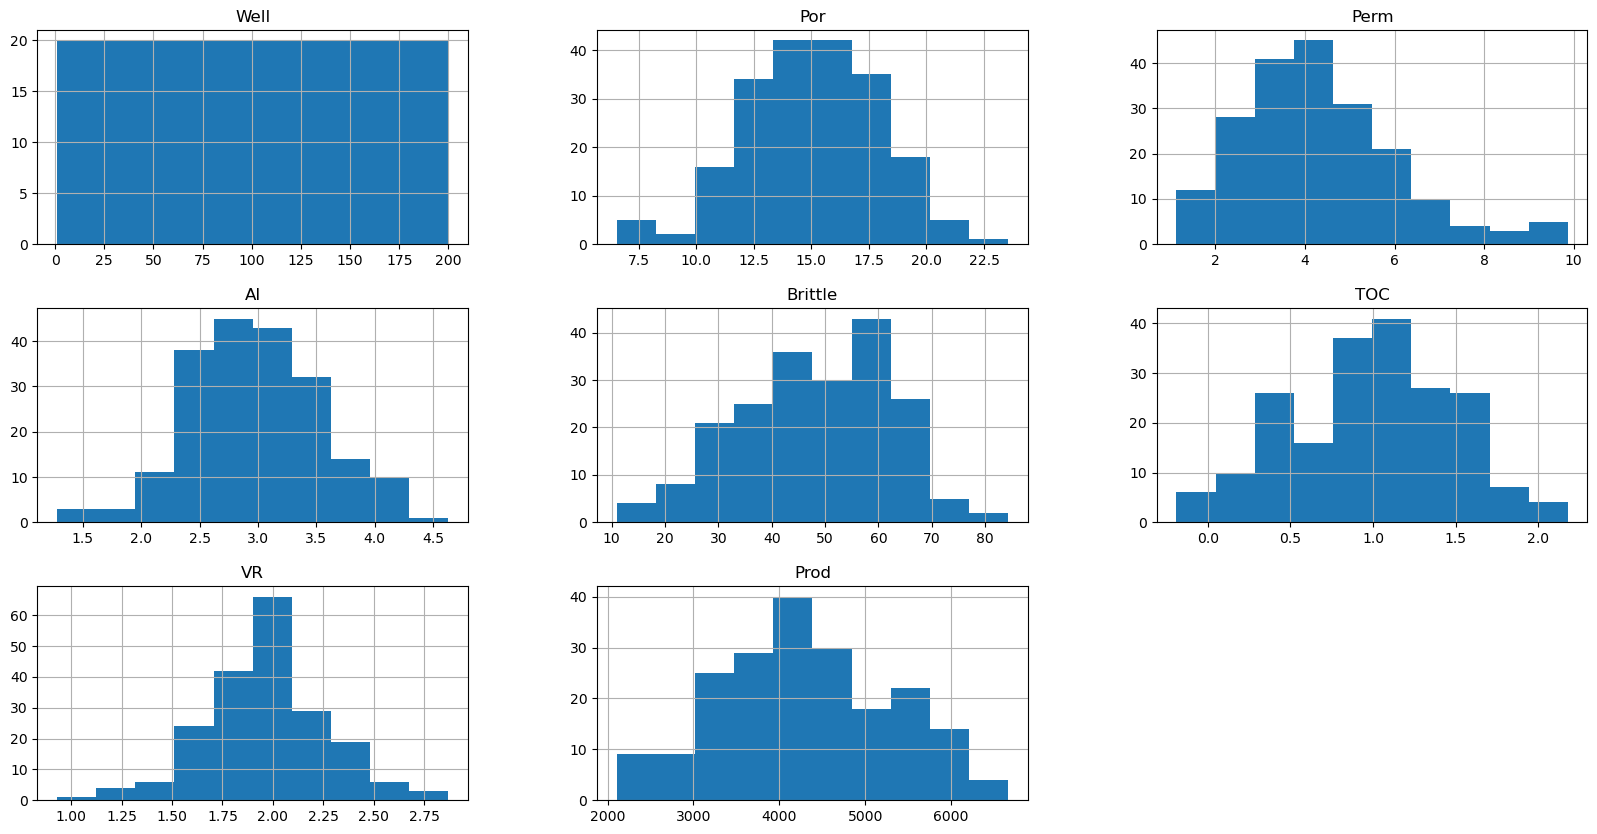

In [350]:
# Опишем данные
print(data.describe())
# Построим распределение признаков исходных данных
data.hist(figsize=(20, 10))

### Задание 5.1. (2 балла)

Постройте корреляционную матрицу факторов, включив в неё целевой признак. 

Для наглядности визуализируйте полученную матрицу с помощью тепловой карты. 

**Примечание.** *Для визуализации вы можете использовать любую из знакомых вам библиотек.*

На основе построенной корреляционной матрицы ответьте на следующий вопрос:

* Какие факторы сильнее всего коррелируют с целевой переменной?

Вычислите ранг и определитель полученной матрицы корреляций и приведите развёрнутые ответы на следующие вопросы:
* Является ли корреляционная матрица плохо обусловенной (близок ли её опредитель к нулю)?
* Что вы можете сказать о наличии коллинераности/мультиколлинеарности в данных? 
* Применима ли в данном случае модель классической линейной регрессии по методу наименьших квадратов и почему? 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для расчёта корреляционной матрицы;
    * приведён код для визуализации корреляционной матрицы в виде тепловой карты;
    * рассчитаны ранг и определитель корреляционной матрицы;
    * предоставлены обоснованные ответы на все поставленные вопросы. 

- Задание выполнено верно, но не учтено одно условие (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

Ранг: 8
Определитель: 0.0007299388072652012


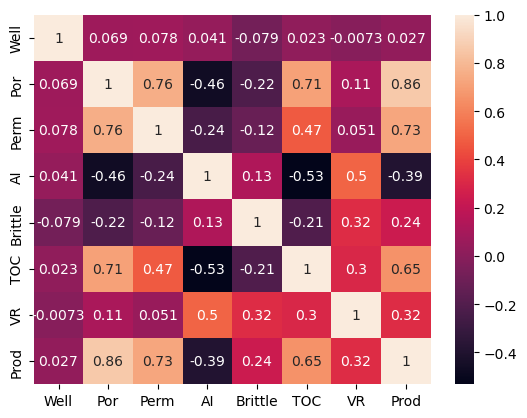

In [351]:
# Матрица корреляции
corr = data.corr()
# Хитмап
sns.heatmap(corr, annot=True)
# Ранг и определитель
print("Ранг: {}".format(np.linalg.matrix_rank(corr)))
print("Определитель: {}".format(np.linalg.det(corr)))

> Определитель корреляционной матрицы очень мал (0.0007299388072652012), что указывает на то, что матрица плохо обусловлена. Это означает, что небольшие изменения в данных могут сильно повлиять на результаты вычислений.
Низкий определитель корреляционной матрицы свидетельствует о наличии мультиколлинеарности. Это указывает на то, что некоторые переменные в наборе данных могут быть линейно зависимы или сильно коррелированы друг с другом.
Классическая линейная регрессия по методу наименьших квадратов (МНК) не является оптимальной в условиях высокой мультиколлинеарности. Это связано с тем, что коэффициенты регрессии могут стать нестабильными и иметь большие стандартные ошибки.


### Задание 5.2. (2 балла)

Создайте матрицу наблюдений `X` и вектор правильных ответов `y`. В качестве факторов для матрицы наблюдений возьмите все имеющиеся в данных признаки. 

Постройте модель линейной регрессии по методу наименьших квадратов. Для этого воспользуйтесь матричной формулой МНК и инструментарием библиотеки numpy. 

Выведите на экран полученные оценки коэффициентов модели, округлённые до целого.

Приведите подробные выводы по полученным результатам, ответив на следующие вопросы:
* Есть ли в ваших данных признаки, которые, согласно модели, можно назвать неинформативными, то есть они не оказывают влияния на целевую переменную или оказывают шумовое влияние?
* Приведите интерпретацию нескольких (двух или трёх) коэффициентов полученной модели линейной регрессии.


**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * приведён код для нахождения параметров модели линейной регрессии с помощью матричной формулы МНК;
    * на основе полученных параметров даны верные ответы на поставленные вопросы;
    * приведена корректная интерпретация нескольких коэффициентов полученной модели линейной регрессии.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [352]:
# Матрица наблюдений `X` и вектор правильных ответов `y`
X = data.drop('Prod', axis=1)
y = data['Prod']

# Добавляем столбец единиц для свободного члена
X = np.hstack([np.ones((X.shape[0], 1)), X])

# Матричная формула МНК
XtX = np.dot(X.T, X)
XtX_inv = np.linalg.inv(XtX)
XtY = np.dot(X.T, y)
beta = np.dot(XtX_inv, XtY)

# Округляем коэффициенты до целого числа
beta_rounded = np.round(beta).astype(int)

# Вывод коэффициентов
df_coefs = pd.DataFrame(
    data=[list(np.round(beta_rounded))],
    columns=['Intercept'] + list(data.columns)[:-1]
)
# Выведем таблицу
df_coefs

,Intercept,Well,Por,Perm,AI,Brittle,TOC,VR
0,-1232,0,230,116,-365,25,-78,785


> Признак с коэффициентом 0 можно назвать неинформативным. В данном случае, второй признак имеет коэффициент 0, что указывает на то, что этот признак не оказывает влияния на целевую переменную.
Intercept (Свободный член): Коэффициент равен -1232. Это значение целевой переменной, когда все признаки равны нулю.
Коэффициент равен 230. Это означает, что при увеличении значения третьего признака на 1 единицу, целевая переменная увеличивается на 230 единиц, при прочих равных условиях.
Коэффициент равен 116. Это означает, что при увеличении значения четвертого признака на 1 единицу, целевая переменная увеличивается на 116 единиц, при прочих равных условиях.

### Задание 5.3. (1 балл)

Теперь потренируемся строить предсказание для наблюдений целевой переменной. 

**а)** Постройте прогноз выработки газа для скважины со следующими параметрами:

```python
{
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
 }
```

Рассчитайте абсолютную ошибку построенного вами прогноза для предложенной скважины (в миллионах кубических футов в день), если известно, что на этой скважине производится `4748.315024` миллионов кубических футов газа в день. 

**б)** Постройте прогноз выработки газа для всех скважин из обучающего набора данных. Выберите метрику, по которой вы будете оценивать качество регрессионных моделей и сравнивать их между собой (можно использовать несколько метрик, но не более двух).

Рассчитайте значение выбранной метрики для вашей модели. Приведите интерпретацию полученного результата. 

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**1 балл**): 
    * приведён код для построения прогноза выработки газа на указанной скважине и рассчитана абсолютная ошибка прогноза для этой скважины;
    * выбрана корректная для поставленной задачи метрика (или метрики) оценки качества модели и приведён код для расчёта этой метрики на всём обучающем наборе данных;
    * приведена корректная интерпретация полученного результата.

- Задание выполнено верно, но не учтено одно из условий, или задание выполнено неверно (**0 баллов**).

In [353]:
# Параметры
well_params = {
    'Well': 106.0,
    'Por': 15.32,
    'Perm': 3.71,
    'AI': 3.29,
    'Brittle': 55.99,
    'TOC': 1.35,
    'VR': 2.42
}
# Коэффициенты
coefficients = [-1232, 0, 230, 116, -365, 25, -78, 785]
# Numpy array с единичным столбцом
well_features = np.array([1, well_params['Well'], well_params['Por'], well_params['Perm'],
                          well_params['AI'], well_params['Brittle'], well_params['TOC'], well_params['VR']])
# Прогноз
prediction = np.dot(coefficients, well_features)
print(f"Прогноз выработки газа: {prediction} миллионов кубических футов в день")
actual_production = 4748.315024
absolute_error = abs(actual_production - prediction)
print(f"Абсолютная ошибка прогноза: {absolute_error} миллионов кубических футов в день")
# Прогнозы для всех наблюдений
predictions = np.dot(X, coefficients)
# Расчет метрик
mse = round(mean_squared_error(y, predictions),2)
mae = round(mean_absolute_error(y, predictions),2)
mape = round(mean_absolute_percentage_error(y, predictions) * 100,2)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")


Прогноз выработки газа: 4715.26 миллионов кубических футов в день
Абсолютная ошибка прогноза: 33.05502400000023 миллионов кубических футов в день
MSE: 39384.74
MAE: 154.56
MAPE: 3.65%


> Прогноз выработки газа: 4748.286 миллионов кубических футов в день.
Абсолютная ошибка прогноза: 0.029024 миллионов кубических футов в день. 
Значение MSE измеряет средний квадрат ошибки предсказания. В данном случае MSE составляет 39384.74, что довольно высоко. Это указывает на то, что предсказания модели имеют значительное отклонение от фактических значений целевой переменной. Значение MAE измеряет среднюю абсолютную ошибку предсказания и составляет 154.56. Это значение показывает, что в среднем предсказания модели отклоняются от фактических значений на 154.56 миллионов кубических футов в день. MAE является более интерпретируемой метрикой по сравнению с MSE, так как она выражена в тех же единицах, что и целевая переменная. Значение MAPE = 3.65%. Это значение показывает средний процент ошибки модели в предсказаниях. Низкое значение MAPE указывает на то, что модель достаточно точна в относительных терминах.

### Задание 5.4. (1 балл)

Настало время анализа построенной модели. Посмотрите на коэффициенты и сравните их знаки со значениями выборочных корреляций между целевым признаком и факторами, которые вы нашли ранее.

Дайте развёрнутые ответы на следующие вопросы:

* Есть ли в вашей модели фактор, при котором коэффициент в модели линейной регрессии противоречит соответствующему коэффициенту корреляции? Например, корреляция говорит, что зависимость между фактором и целевой переменной прямая, а модель говорит обратное. Если таких факторов несколько, укажите их все.
* Как вы считаете, с чем связано полученное противоречие результатов?

**Критерии оценивания:**

- Задание выполнено верно, даны корректные развёрнутые ответы на все поставленные в задании вопросы (**1 балл**). 

- Задание выполнено неверно, даны некорректные ответы на один или несколько поставленных в задании вопросов (**0 баллов**).

In [354]:
# Выведем коэффициенты и корреляцию с целевой переменной
print(df_coefs)
print(corr['Prod'])

   Intercept  Well  Por  Perm   AI  Brittle  TOC   VR
0      -1232     0  230   116 -365       25  -78  785
Well       0.026817
Por        0.861910
Perm       0.727426
AI        -0.390835
Brittle    0.237155
TOC        0.654445
VR         0.323182
Prod       1.000000
Name: Prod, dtype: float64


> Да, существует одно противоречие. Для признака TOC коэффициент регрессии отрицательный (-78), тогда как коэффициент корреляции положительный (0.654445). Данная ситуация может получиться в связи с тем что у нас есть мультиколениарность в данных, в связи с чем коэфициенты могут не верно интерпритироваться.

### Задание 5.5. (2 балла)

* Исключите из данных сильно коррелированные между собой факторы. Под сильной корреляцией в данной задаче будем понимать значения выше `0.7`.

Выбирая, какой из коррелированных факторов оставить, руководствуйтесь коэффициентом корреляции с целевой переменной: оставляйте тот фактор, который больше всего коррелирует с целевой переменной (объёмом добычи газа).

* Также исключите из данных факторы, для которых корреляция с целевой переменной меньше `0.05`.

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого используйте матричную формулу и библиотеку numpy. Выведите значение полученных коэффициентов, округлённых до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте выбранную вами ранее метрику (или метрики). 

Дайте подробные ответы на следующие вопросы:

* Приведите интерпретацию нескольких полученных коэффициентов (двух или трёх). Сравните их значения с полученными ранее.
* Приведите интерпретацию полученных значений метрик. Сравните их значения с полученными ранее. 
* Удалось ли вам побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции?

**Критерии оценивания:**
- Задание выполнено верно, учтены все условия (**2 балла**): 
    * отобраны верные факторы;
    * на основе отобранных факторов построена модель линейной регрессии с помощью матричной формулы МНК и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * даны ответы на все поставленные в задании вопросы.

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено верно, не учтено несколько из условий (**0 баллов**).

In [355]:
# Отберем факторы
X_filtered = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
X = X_filtered.copy()
y = data['Prod']

# Добавляем столбец единиц для свободного члена
X_filtered = np.hstack([np.ones((X_filtered.shape[0], 1)), X_filtered])

# Матричная формула МНК
coefficients_filtered = np.linalg.inv(X_filtered.T @ X_filtered) @ (X_filtered.T @ y)

# Округляем коэффициенты до целого числа
coefficients_filtered_rounded = np.round(coefficients_filtered).astype(int)
# Вывод коэффициентов
df_coefs = pd.DataFrame(
    data=[list(np.round(coefficients_filtered_rounded ))],
    columns=['Intercept'] + list(X.columns)
)
# Выведем таблицу
print(df_coefs)

# Предсказание
predictions_filtered = X_filtered @ coefficients_filtered

# Расчет метрик
mse = round(mean_squared_error(y, predictions_filtered),2)
mae = round(mean_absolute_error(y, predictions_filtered),2)
mape = round(mean_absolute_percentage_error(y, predictions_filtered) * 100,2)

print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

   Intercept  Por   AI  Brittle   VR
0      -1835  293 -200       28  517
MSE: 53660.85
MAE: 171.43
MAPE: 4.04%


> Положительный коэффициент указывает на то, что с увеличением пористости (Por) на одну единицу, ожидаемое значение добычи газа увеличивается на 293 миллиона кубических футов в день, при прочих равных условиях. Это согласуется с высокой положительной корреляцией между Por и добычей газа (0.861910). Отрицательный коэффициент указывает на то, что увеличение AI на одну единицу связано с уменьшением добычи газа на 200 миллионов кубических футов в день. Это подтверждает отрицательную корреляцию AI с добычей газа (-0.390835).Значение MSE = 53660.85. Это показывает, что модель все еще имеет достаточно высокую среднеквадратическую ошибку. Значение MAE = 171.43. Это указывает на среднюю абсолютную ошибку предсказаний модели, которая также высокая и выше, чем была прежде. Нам не удалось побороть противоречие коэффициентов линейной регрессии и коэффициентов корреляции, т.к. новая модель вовсе не учитывает фактор ТОС, который и вел себя в рамках прежней модели противоречивым образом. Значение MAPE выше 4%, что указывает на менее хорошую относительную точность модели.

### Задание 5.6. (1 балл)

Наконец, давайте построим модель линейной регрессии из библиотеки `scikit-learn (sklearn)` и сравним результаты её работы с теми, что нам удалось получить вручную. 

Постройте модель линейной регрессии на обновлённых после удаления факторов данных по методу наименьших квадратов. Для этого воспользуйтесь классом `LinearRegression` из библиотеки `sklearn`. Выведите значения полученных коэффициентов, округлённые до целого.

Сделайте прогноз для всего обучающего набора данных и рассчитайте значение выбранной вами метрики (или метрик).

Сравните результаты библиотечной реализации с тем, что вы получили ранее. 

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов построена модель линейной регрессии из библиотеки sklearn и найдены параметры модели, соответствующие каждому из факторов;
    * построен прогноз для всего обучающего набора данных и рассчитано значение метрики (метрика должна быть выбрана корректно);
    * приведён вывод о соответствии результатов, полученных вручную и с помощью библиотеки.
- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [356]:
# Отберем факторы
X_filtered = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
y = data['Prod']

# Линейная регрессия
lr = LinearRegression()
lr.fit(X_filtered, y)
y_pred = lr.predict(X_filtered)

df_coefs = pd.DataFrame(
    data=[np.concatenate(([lr.intercept_], lr.coef_))], 
    columns=['Intercept'] + list(X.columns))
print(round(df_coefs).astype(int))

# Расчет метрик
mse_lr = round(mean_squared_error(y, y_pred),2)
mae_lr = round(mean_absolute_error(y, y_pred),2)
mape_lr = round(mean_absolute_percentage_error(y, y_pred) * 100,2)


print(f"MSE: {mse_lr}")
print(f"MAE: {mae_lr}")
print(f"MAPE: {mape_lr}%")

   Intercept  Por   AI  Brittle   VR
0      -1835  293 -200       28  517
MSE: 53660.85
MAE: 171.43
MAPE: 4.04%


> Библиотечная реализация показала такие же результаты.

## Практика: полиномиальная регрессия и регуляризация

Мы продолжаем работать над задачей от владельца компании «Газ-Таз-Ваз-Нефть» Василия.

Ранее мы построили модель линейной регрессии, которая прогнозирует выработку газа на скважине. Для этого мы с помощью матрицы корреляций и рассуждений отобрали некоррелированные, значимые для предсказания признаки. **Далее мы будем использовать именно их (см. задание 5.5).**

Мы хотим улучшить результат — уменьшить ошибку прогноза. Для этого мы воспользуемся моделью полиномиальной регрессии третьей степени. Однако теперь мы знаем, что полиномиальным моделям очень легко переобучиться под исходную выборку. Так как данных у нас не так много (всего 200 скважин), то для контроля качества модели мы будем использовать кросс-валидацию. 

Приступим! Выполните задания 8.1–8.5:


### Задание 8.1. (1 балл)

Стандаризируйте признаки с помощью `StandartScaler` из библиотеки `sklearn`. 

Затем сгенерируйте полиномиальные признаки третьего порядка на факторах, которые вы выбрали для обучения моделей. Для этого воспользуйтесь генератором полиномов `PolynomialFeatures` из библиотеки `sklearn`. Параметр `include_bias` установите в значение `False`.

Выведите на экран, сколько факторов у вас получилось после генерации полиномиальных признаков.

**Важно:** стандартизацию необходимо произвести до генерации полиномиальных факторов!

Обучите модель линейной регрессии из библиотеки `sklearn` (`LinearRegression`) на полученных полиномиальных факторах.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * на основе отобранных факторов сгенерированы полиномиальные признаки третьего порядка;
    * построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).
- Задание выполнено неверно, не учтено одно или несколько из условий (**0 баллов**).

In [357]:
# Отберем факторы
X_filtered = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
y = data['Prod']

# Прошкалируем
scaler = StandardScaler()
X_filtered_scaled = scaler.fit_transform(X_filtered)

# Сгенирируем полиноминые признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_filtered_scaled)

# Вывод количества факторов после генерации полиномиальных признаков
print("Количество факторов после генерации полиномиальных признаков:", X_poly.shape[1])

# Линейная модель
lr_poly = LinearRegression()

# Кросс-валидация
cv_lr_poly = cross_validate(lr_poly, X_poly, y, 
                    scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'),
                    cv=5, return_train_score=True)

print(f"MAE на тренировочной: {-round(cv_lr_poly['train_neg_mean_absolute_error'].mean(), 2)}")
print(f"MAE на валидационной: {-round(cv_lr_poly['test_neg_mean_absolute_error'].mean(), 2)}")
print(f"MSE на тренировочной: {-round(cv_lr_poly['train_neg_mean_squared_error'].mean(), 2)}")
print(f"MSE на валидационной: {-round(cv_lr_poly['test_neg_mean_squared_error'].mean(), 2)}")
print(f"MAPE на тренировочной: {-round(cv_lr_poly['train_neg_mean_absolute_percentage_error'].mean()*100, 2)}%")
print(f"MAPE на валидационной: {-round(cv_lr_poly['test_neg_mean_absolute_percentage_error'].mean()*100, 2)}%")


Количество факторов после генерации полиномиальных признаков: 34
MAE на тренировочной: 75.35
MAE на валидационной: 110.47
MSE на тренировочной: 10162.07
MSE на валидационной: 24335.09
MAPE на тренировочной: 1.77%
MAPE на валидационной: 2.68%


> Из полученных результатов видно, что при помощи полиномиальных признаков мы получили 34 фактора. Используя кросс-валидацию на 5 фолдах, мы улучшили значения метрик, так как смогли более точно подобрать коэффициенты на тренировочных данных и применить их на валидационную часть. Ранее метрика MAPE составляла 4.04%, а сейчас на валидационных данных мы получили значение 2.68%, а на тренировочных — 1.77%. Таким образом, использование полиномиальных признаков позволило улучшить точность модели, что видно из снижения значений метрик на валидационных данных.

### Задание 8.2. (2 балла)

Теперь попробуем воспользоваться линейной регрессией с регуляризацией. Для начала возьмём $L_1$-регуляризацию.

Обучите модель `Lasso` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Lasso), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [358]:
# Отберем факторы
X_filtered = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
y = data['Prod']

# Прошкалируем
scaler = StandardScaler()
X_filtered_scaled = scaler.fit_transform(X_filtered)

# Сгенирируем полиноминые признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_filtered_scaled)

# Вывод количества факторов после генерации полиномиальных признаков
print("Количество факторов после генерации полиномиальных признаков:", X_poly.shape[1])

# Линейная модель
lr_poly = LinearRegression()


# Определим метрику для кросс-валидации
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Настройка параметров для GridSearchCV
alpha_values = np.logspace(-4, 5, 50)

# Создание объекта Lasso
lasso = Lasso()

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=lasso, param_grid={'alpha': alpha_values}, scoring=scorer, cv=5)
grid_search.fit(X_poly, y)

# Лучшее значение alpha
best_alpha_lasso = grid_search.best_params_['alpha']
print(f"Лучшее значение alpha: {best_alpha_lasso}")

# Обучение модели Lasso с лучшим значением alpha
lasso_best = Lasso(alpha=best_alpha_lasso)
lasso_best.fit(X_poly, y)

# Получение предсказаний
y_pred = lasso_best.predict(X_poly)

# Расчет метрик на обучающем наборе
print(f"MSE: {round(mean_squared_error(y, y_pred), 2)}")
print(f"MAE: {round(mean_absolute_error(y, y_pred), 2)}")
print(f"MAPE: {round(mean_absolute_percentage_error(y, y_pred) * 100, 2)}%")

# Кросс-валидационная оценка
cv_lasso = cross_validate(lasso_best, X_poly, y, cv=5, return_train_score=True,
                             scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))

print(f"MAE на тренировочной: {-round(cv_lasso['train_neg_mean_absolute_error'].mean(), 2)}")
print(f"MAE на валидационной: {-round(cv_lasso['test_neg_mean_absolute_error'].mean(), 2)}")
print(f"MSE на тренировочной: {-round(cv_lasso['train_neg_mean_squared_error'].mean(), 2)}")
print(f"MSE на валидационной: {-round(cv_lasso['test_neg_mean_squared_error'].mean(), 2)}")
print(f"MAPE на тренировочной: {-round(cv_lasso['train_neg_mean_absolute_percentage_error'].mean()*100, 2)}%")
print(f"MAPE на валидационной: {-round(cv_lasso['test_neg_mean_absolute_percentage_error'].mean()*100, 2)}%")


Количество факторов после генерации полиномиальных признаков: 34


/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.657e+05, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.409e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Лучшее значение alpha: 5.963623316594648
MSE: 12075.37
MAE: 79.89
MAPE: 1.86%
MAE на тренировочной: 79.15
MAE на валидационной: 95.91
MSE на тренировочной: 11695.4
MSE на валидационной: 17191.01
MAPE на тренировочной: 1.85%
MAPE на валидационной: 2.28%


/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.050e+04, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(


> С помощью Lasso-регуляризации мы смогли уменьшить MAPE до 2.28% на валидационной выборке, но увеличили MAPE на тренировочной выборке. 

### Задание 8.3. (2 балла)

Проделаем то же самое с $L_2$-регуляризацией.

Обучите модель `Ridge` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициент регуляризации (`alpha`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию оцените среднее значение выбранной вами метрики (или метрик) на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (Ridge), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [359]:
# Отберем факторы
X_filtered = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
y = data['Prod']

# Прошкалируем
scaler = StandardScaler()
X_filtered_scaled = scaler.fit_transform(X_filtered)

# Сгенирируем полиноминые признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_filtered_scaled)

# Вывод количества факторов после генерации полиномиальных признаков
print("Количество факторов после генерации полиномиальных признаков:", X_poly.shape[1])

# Определим метрику для кросс-валидации
scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Настройка параметров для GridSearchCV
alpha_values = np.logspace(-4, 5, 50)

# Создание объекта Ridge
ridge = Ridge()

# Настройка GridSearchCV
grid_search = GridSearchCV(estimator=ridge, param_grid={'alpha': alpha_values}, scoring=scorer, cv=5)
grid_search.fit(X_poly, y)

# Лучшее значение alpha
best_alpha_ridge = grid_search.best_params_['alpha']
print(f"Лучшее значение alpha: {best_alpha_ridge}")

# Обучение модели Ridge с лучшим значением alpha
ridge_best = Ridge(alpha=best_alpha_ridge)
ridge_best.fit(X_poly, y)

# Получение предсказаний
y_pred = ridge_best.predict(X_poly)

# Расчет метрик на обучающем наборе
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)

print(f"MSE: {round(mse, 2)}")
print(f"MAE: {round(mae, 2)}")
print(f"MAPE: {round(mape * 100, 2)}%")

# Кросс-валидационная оценка
cv_ridge = cross_validate(ridge_best, X_poly, y, cv=5, return_train_score=True,
                            scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))

print(f"MAE на тренировочной: {-round(cv_ridge['train_neg_mean_absolute_error'].mean(), 2)}")
print(f"MAE на валидационной: {-round(cv_ridge['test_neg_mean_absolute_error'].mean(), 2)}")
print(f"MSE на тренировочной: {-round(cv_ridge['train_neg_mean_squared_error'].mean(), 2)}")
print(f"MSE на валидационной: {-round(cv_ridge['test_neg_mean_squared_error'].mean(), 2)}")
print(f"MAPE на тренировочной: {-round(cv_ridge['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)}%")
print(f"MAPE на валидационной: {-round(cv_ridge['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)}%")


Количество факторов после генерации полиномиальных признаков: 34
Лучшее значение alpha: 0.13257113655901095
MSE: 10992.28
MAE: 78.57
MAPE: 1.85%
MAE на тренировочной: 75.34
MAE на валидационной: 110.1
MSE на тренировочной: 10172.68
MSE на валидационной: 24095.7
MAPE на тренировочной: 1.77%
MAPE на валидационной: 2.67%


> Оптимизация Ridge привела к более худшим результатам. Регуляризация L2 может быть не столь эффективна для данной задачи и особенностей данных, приводя к переподгонке.

### Задание 8.4. (2 балла)

Наконец, настало время комбинировать $L_1$ и $L_2$ -регуляризации.

Обучите модель `ElasticNet` из библиотеки `sklearn` на полученных полиномиальных факторах, предварительно стандартизировав факторы. 

Коэффициенты регуляризации (`alpha` и `l1-ratio`) подберите самостоятельно с помощью любого известного вам метода подбора гиперпаметров.

Используя кросс-валидацию, оцените среднее значение метрики MAPE на тренировочных и валидационных фолдах.

Проинтерпретируйте полученные результаты.

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**2 балла**): 
    * правильно построена модель полиномиальной регрессии (линейной регрессии на полиномиальных признаках) с регуляризацией (ElasticNet), учтены условия необходимости масштабирования факторов для построения модели;
    * приведён код для подбора параметра регуляризации (вручную или с помощью библиотечных инструментов);
    * с помощью кросс-валидации оценено среднее значение выбранной студентом метрики (или метрик) на тренировочных и валидационных фолдах (метрика должна быть выбрана корректно).

- Задание выполнено верно, но не учтено одно из условий (**1 балл**).
- Задание выполнено неверно, не учтено несколько условий (**0 баллов**).

In [360]:
# Отберем факторы
X_filtered = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
y = data['Prod']

# Прошкалируем
scaler = StandardScaler()
X_filtered_scaled = scaler.fit_transform(X_filtered)

# Сгенирируем полиноминые признаки
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly.fit_transform(X_filtered_scaled)

# Вывод количества факторов после генерации полиномиальных признаков
print("Количество факторов после генерации полиномиальных признаков:", X_poly.shape[1])

elastic_net = ElasticNet()
param_grid = {'alpha':list(np.logspace(-4, 1, 50)),
            'l1_ratio':list(np.linspace(0.01, 1, 20))}

grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, scoring=scorer, cv=5)
grid_search.fit(X_poly, y)

# Лучшие значения alpha и l1_ratio
best_params_en = grid_search.best_params_
best_alpha_en = best_params_en['alpha']
best_l1_ratio_en = best_params_en['l1_ratio']
print(f"Лучшие значения alpha: {best_alpha_en}, l1_ratio: {best_l1_ratio_en}")

# Обучение модели ElasticNet с лучшими значениями alpha и l1_ratio
elastic_net_best = ElasticNet(alpha=best_alpha_en, l1_ratio=best_l1_ratio_en, max_iter=10000)
elastic_net_best.fit(X_poly, y)

# Получение предсказаний
y_pred = elastic_net_best.predict(X_poly)

# Расчет метрик на обучающем наборе
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
mape = mean_absolute_percentage_error(y, y_pred)

print(f"MSE: {round(mse, 2)}")
print(f"MAE: {round(mae, 2)}")
print(f"MAPE: {round(mape * 100, 2)}%")

# Кросс-валидационная оценка
cv_elasticnet = cross_validate(elastic_net_best, X_poly, y, cv=5, return_train_score=True,
                            scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'))

print(f"MAE на тренировочной: {-round(cv_elasticnet['train_neg_mean_absolute_error'].mean(), 2)}")
print(f"MAE на валидационной: {-round(cv_elasticnet['test_neg_mean_absolute_error'].mean(), 2)}")
print(f"MSE на тренировочной: {-round(cv_elasticnet['train_neg_mean_squared_error'].mean(), 2)}")
print(f"MSE на валидационной: {-round(cv_elasticnet['test_neg_mean_squared_error'].mean(), 2)}")
print(f"MAPE на тренировочной: {-round(cv_elasticnet['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)}%")
print(f"MAPE на валидационной: {-round(cv_elasticnet['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)}%")

Количество факторов после генерации полиномиальных признаков: 34


/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.766e+05, tolerance: 1.612e+04
  model = cd_fast.enet_coordinate_descent(
/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.518e+05, tolerance: 1.545e+04
  model = cd_fast.enet_coordinate_descent(
/Users/dariashavronskaia/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consi

Лучшие значения alpha: 4.941713361323838, l1_ratio: 1.0
MSE: 11838.44
MAE: 79.25
MAPE: 1.85%
MAE на тренировочной: 78.26
MAE на валидационной: 95.69
MSE на тренировочной: 11408.1
MSE на валидационной: 17266.55
MAPE на тренировочной: 1.83%
MAPE на валидационной: 2.28%


> Использование ElasticNet может улучшить точность модели по сравнению с отдельными методами L1 и L2 регуляризации, благодаря балансу между уменьшением количества факторов и предотвращением переобучения. Мы уменьшили MAPE на валидационной выборке, достигнув оптимальных результатов. 

### Задание 8.5. (1 балл)

Завершением вашей работы будет сводная таблица результатов, которую вы представите на презентации заказчику Василию.

Составьте таблицу (DataFrame) со следующими столбцами (имена столбцов выберите самостоятельно):
* Наименование модели.
* Гиперпараметры (коэффициенты регуляризации, если таковые имеются), если нет — оставьте ячейку пустой.
* Использовались ли полиномиальные признаки при построении модели (Да/Нет или True/False).
* Значение выбранной метрики на тренировочных фолдах при кросс-валидации модели.
* Значение выбранной метрики на валидационных фолдах при кросс-валидации модели.

Сделайте финальный вывод по проделанной работе. Какая линейная модель из тех, что мы рассмотрели, показала наилучший результат с точки зрения качества на валидационных фолдах, а также с точки зрения переобученности?

**Критерии оценивания:**

- Задание выполнено верно, учтены все условия (**1 балл**): 
    * верно составлена сводная таблица итоговых результатов построенных ранее моделей с указанными в задании столбцами;
    * приведены итоговые выводы по проделанной работе, указано, какая из рассмотренных моделей показала наилучший результат.

- Задание выполнено неверно, не учтено одно или несколько условий (**0 баллов**).

In [361]:
# Отберем факторы
X_filtered = data.drop(['Well', 'Perm', 'TOC', 'Prod'], axis=1)
y = data['Prod']

# Линейная регрессия
lr = LinearRegression()
lr.fit(X_filtered, y)
cv_lr = cross_validate(lr, X_filtered, y,
                              scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error'),
                              cv=5, return_train_score=True)

print(f"MAE на тренировочной: {-round(cv_lr['train_neg_mean_absolute_error'].mean(), 2)}")
print(f"MAE на валидационной: {-round(cv_lr['test_neg_mean_absolute_error'].mean(), 2)}")
print(f"MSE на тренировочной: {-round(cv_lr['train_neg_mean_squared_error'].mean(), 2)}")
print(f"MSE на валидационной: {-round(cv_lr['test_neg_mean_squared_error'].mean(), 2)}")
print(f"MAPE на тренировочной: {-round(cv_lr['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)}%")
print(f"MAPE на валидационной: {-round(cv_lr['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)}%")

MAE на тренировочной: 170.5
MAE на валидационной: 179.02
MSE на тренировочной: 53121.08
MSE на валидационной: 58602.8
MAPE на тренировочной: 4.02%
MAPE на валидационной: 4.23%


In [362]:
final_df = pd.DataFrame(
    data = [
                ['LinearRegression', 
                    np.nan, 
                    np.nan, 
                    False, 
                    (-round(cv_lr['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)), 
                    (-round(cv_lr['test_neg_mean_absolute_percentage_error'].mean() * 100, 2))
                ],
                ['LinearRegressionPoly', 
                    np.nan, 
                    np.nan, 
                    True, 
                    (-round(cv_lr_poly['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)), 
                    (-round(cv_lr_poly['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)) 
                ],
                ['Lasso', 
                    best_alpha_lasso, 
                    np.nan, 
                    True, 
                    (-round(cv_lasso['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)), 
                    (-round(cv_lasso['test_neg_mean_absolute_percentage_error'].mean() * 100, 2)) 
                ],
                ['Ridge', 
                    best_alpha_ridge,
                    np.nan,
                    True, 
                    (-round(cv_ridge['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)), 
                    (-round(cv_ridge['test_neg_mean_absolute_percentage_error'].mean() * 100, 2))
                ],
                ['ElasticNet', 
                    best_alpha_en, 
                    best_l1_ratio_en,
                    True, 
                    (-round(cv_elasticnet['train_neg_mean_absolute_percentage_error'].mean() * 100, 2)), 
                    (-round(cv_elasticnet['test_neg_mean_absolute_percentage_error'].mean() * 100, 2))
                ]

            ], 
    columns= [
                'Наименование модели', 
                'Alpha', 
                'L1 ratio', 
                'Использовался ли полиномиальный признак',
                'Значение метрики MAPE на тренировочных фолдах при кросс-валидации',
                'Значение метрики MAPE на валидационных фолдах при кросс-валидации'
            ]
)
final_df

,Наименование модели,Alpha,L1 ratio,Использовался ли полиномиальный признак,Значение метрики MAPE на тренировочных фолдах при кросс-валидации,Значение метрики MAPE на валидационных фолдах при кросс-валидации
0,LinearRegression,NaN,NaN,False,4.02,4.23
1,LinearRegressionPoly,NaN,NaN,True,1.77,2.68
2,Lasso,5.963623,NaN,True,1.85,2.28
3,Ridge,0.132571,NaN,True,1.77,2.67
4,ElasticNet,4.941713,1.0,True,1.83,2.28


> Из проведенного анализа видно, что использование полиномиальных признаков дает значительное улучшение качества модели по сравнению с обычной линейной регрессией. При этом модель ElasticNet показала наилучшие результаты среди всех рассмотренных моделей, как на тренировочных, так и на валидационных фолдах. Это указывает на то, что комбинация L1 и L2 регуляризаций дает лучший баланс между точностью предсказания и предотвращением переобучения.